In [0]:
print("hi")

hi


In [0]:
%pip install pandas

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Import necessary libraries
import pandas as pd

# Define the path to the CSV file
file_path = '/dbfs/FileStore/shared_uploads/adimodi10@gmail.com/loan.csv'

# Load the dataset using Pandas
loan_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
loan_data.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000,Not Verified,Dec-18,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-01,1,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,...,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000,Source Verified,Dec-18,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-87,0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,...,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280,Source Verified,Dec-18,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-11,0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,...,0,0,136927,11749,13800,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000,Source Verified,Dec-18,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0,Feb-06,0,NaN,NaN,10,0,5468,78.1,13,w,3831.93,3831.93,286.71,286.71,...,0,0,385183,36151,5000,44984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250,Not Verified,Dec-18,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0,Dec-00,0,NaN,NaN,12,0,829,3.6,26,w,29339.02,29339.02,1423.21,1423.21,...,0,0,157548,29674,9300,32332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("SimpleCreditRiskAssessment").getOrCreate()

# Load the dataset
file_path = "dbfs:/FileStore/shared_uploads/adimodi10@gmail.com/loan.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the dataset
df.show()


+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+-------+-----------+----------+----+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

In [0]:
# Drop rows with missing values
df_cleaned = df.dropna()

# Show the cleaned data to verify
df_cleaned.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+---+----+-------+-----+--------+----------+---+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--------------

In [0]:
print(f"Number of records in the cleaned DataFrame: {df_cleaned.count()}")

df_cleaned.groupBy('loan_status').count().show()



Number of records in the cleaned DataFrame: 0
+-----------+-----+
|loan_status|count|
+-----------+-----+
+-----------+-----+



In [0]:
from pyspark.sql.functions import when

# Create a binary target variable 'loan_status_binary'
df_cleaned = df_cleaned.withColumn('loan_status_binary', when(df_cleaned['loan_status'] == 'Charged Off', 1).otherwise(0))

# Select relevant columns
df_selected = df_cleaned.select('loan_amnt', 'int_rate', 'annual_inc', 'loan_status_binary')

# Show the selected data to verify
df_selected.show()


+---------+--------+----------+------------------+
|loan_amnt|int_rate|annual_inc|loan_status_binary|
+---------+--------+----------+------------------+
+---------+--------+----------+------------------+



In [0]:
# Assemble feature columns into a single feature vector
assembler = VectorAssembler(inputCols=['loan_amnt', 'int_rate', 'annual_inc'], outputCol='features')
df_features = assembler.transform(df_selected)

# Check the assembled data
df_features.select('loan_amnt', 'int_rate', 'annual_inc', 'features', 'loan_status_binary').show()


+---------+--------+----------+--------+------------------+
|loan_amnt|int_rate|annual_inc|features|loan_status_binary|
+---------+--------+----------+--------+------------------+
+---------+--------+----------+--------+------------------+



In [0]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

In [0]:
print(f"Number of records in training set: {train_data.count()}")
print(f"Number of records in testing set: {test_data.count()}")


Number of records in training set: 0
Number of records in testing set: 0


In [0]:
print(f"Number of records in training set: {train_data.count()}")
print(f"Number of records in testing set: {test_data.count()}")

Number of records in training set: 0
Number of records in testing set: 0


+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+-------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------

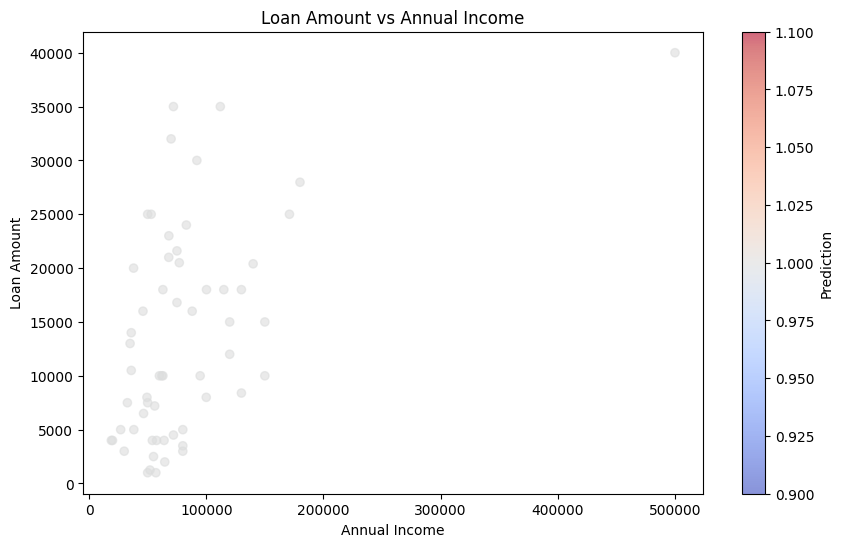

In [0]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("SimpleCreditRiskAssessment").getOrCreate()

file_path = "dbfs:/FileStore/shared_uploads/adimodi10@gmail.com/loan.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)


# Show the first few rows of the dataset
df.show(5)

# Create a binary target variable 'loan_status_binary'
# Assuming 'Fully Paid' is 0 and 'Current' is 1
df = df.withColumn('loan_status_binary', when(df['loan_status'] == 'Current', 1).otherwise(0))

# Select relevant columns for features and target
df = df.select('loan_amnt', 'int_rate', 'annual_inc', 'loan_status_binary')

# Assemble feature columns into a single feature vector
assembler = VectorAssembler(inputCols=['loan_amnt', 'int_rate', 'annual_inc'], outputCol='features')
df = assembler.transform(df)

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='loan_status_binary')

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Show the predictions
predictions.select('loan_amnt', 'int_rate', 'annual_inc', 'loan_status_binary', 'prediction').show(5)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='loan_status_binary')
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

# Visualize the results
predictions_pd = predictions.select('loan_amnt', 'int_rate', 'annual_inc', 'loan_status_binary', 'prediction').toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['annual_inc'], predictions_pd['loan_amnt'], c=predictions_pd['prediction'], cmap='coolwarm', alpha=0.6)
plt.title('Loan Amount vs Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.colorbar(label='Prediction')
plt.show()
